#**readme**
1. Use Google Colab for pre installed Libraries
1. Load the dataset into your environment
2. Change the path in cell 3
3. Run all cells and see results
4. For loading model give correct path where you saved the model (check cell 20 and 25)
5. Give tweet as an user input in the text box at last cell

# **Imports & Load dataset**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re

In [3]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])

#**DATA_EXPLORATION**

In [4]:
# Display the first few rows of the dataframe
print(df.head())

# Get a concise summary of the dataframe
print(df.info())

# Show basic statistical details
print(df.describe())


   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------

In [5]:
# Check for missing values in the dataset
print(df.isnull().sum())


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


target
0    800000
4    800000
Name: count, dtype: int64


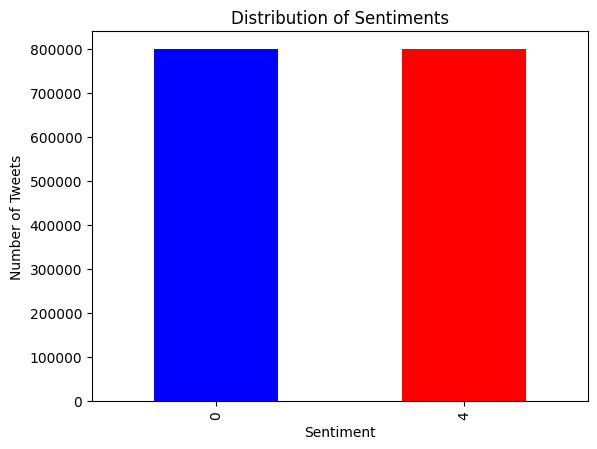

In [6]:
# Count the number of entries for each sentiment
print(df['target'].value_counts())

# Plotting the distribution of sentiments
import matplotlib.pyplot as plt
df['target'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


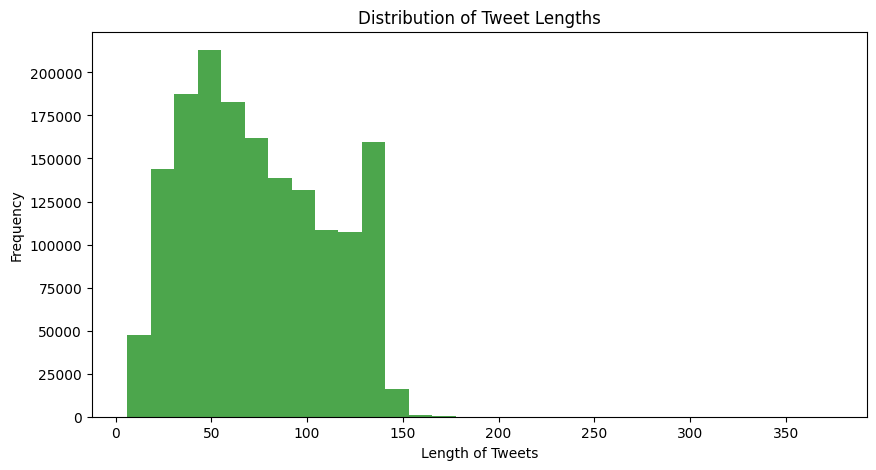

In [7]:
# Calculate the length of each tweet
df['tweet_length'] = df['text'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(10, 5))
plt.hist(df['tweet_length'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.show()


Most common words: [('to', 552962), ('I', 496619), ('the', 487501), ('a', 366212), ('my', 280025), ('and', 275263), ('i', 250016), ('is', 217693), ('you', 213871), ('for', 209801)]


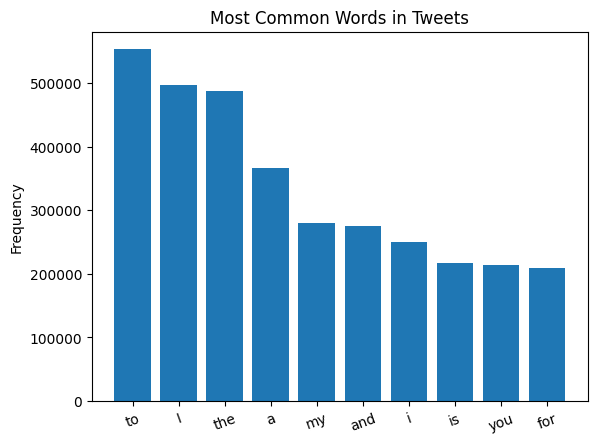

In [9]:
from collections import Counter

# Tokenize the text and count word occurrences
word_counts = Counter(" ".join(df['text']).split())

# Most common words
most_common_words = word_counts.most_common(10)
print("Most common words:", most_common_words)

# Plotting the most common words
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.title('Most Common Words in Tweets')
plt.xticks(rotation=20)
plt.ylabel('Frequency')
plt.show()


#**Data_Pre_processing**

In [10]:
# Preprocessing function
def preprocess_text(sen):
    # Remove URLs, mentions, and special characters
    sentence = re.sub(r'http\S+|www\S+|@\S+', '', sen)
    sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
    # Single character removal and extra spaces
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence.strip()

# Apply preprocessing to each tweet
df['text'] = df['text'].apply(preprocess_text)



In [39]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,that a bummer You shoulda got David Carr of Th...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can update his Facebook by te...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times for the ball Managed to save ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it not behaving at all m mad why am here be...


In [11]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index

In [12]:
# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['text'])

# Pad sequences to ensure uniform input size
padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

In [13]:
# Prepare target variable, converting the labels to a numpy array
labels = df['target'].values
labels[labels == 4] = 1  # '4' indicates a positive sentiment

from sklearn.model_selection import train_test_split

# First, separate out a test set
X_train_val, X_test, y_train_val, y_test = train_test_split(padded, labels, test_size=0.75, random_state=0)
# Now, split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split( X_train_val, y_train_val, test_size=0.2, random_state=0)  # ~25% of original data goes here


#**Defining_Metrics**

In [14]:

from tensorflow.keras.metrics import Precision, Recall

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


#**Model_Building**

In [15]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=200),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', Precision(), Recall(), F1Score()])


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [17]:
# Model summary
model.summary()

# Train the model with early stopping
num_epochs = 50
history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    validation_data=(X_val, y_val),  # Using the validation set here
    verbose=2,
    callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10000/10000 - 70s - loss: 0.5158 - accuracy: 0.7491 - precision: 0.7396 - recall: 0.7693 - f1_score: 0.7541 - val_loss: 0.4698 - val_accuracy: 0.7859 - val_precision: 0.7905 - val_recall: 0.7785 - val_f1_score: 0.7845 - 70s/epoch - 7ms/step
Epoch 2/50
10000/10000 - 45s - loss: 0.4558 - accuracy: 0.7912 - precision: 0.7948 - recall: 0.7854 - f1_score: 0.7901 - val_loss: 0.4652 - val_accuracy: 0.7790 - val_precision: 0.8429 - val_recall: 0.6864 - val_f1_score: 0.7567 - 45s/epoch - 5ms/step
Epoch 3/50
10000/10000 - 41s - loss: 0.4401 - accuracy: 0.7970 - precision: 0.8015 - recall: 0.7897 - f1_score: 0.7956 - val_loss: 0.4617 - val_accuracy: 0.7809 - val_precision: 0.7502 - val_recall: 0.8430 - val_f1_score: 0.7939 - 41s/epoch - 4ms/step
Epoch 4/50
10000/10000 - 47s - loss: 0.4324 - accuracy: 0.7998 - precision: 0.8041 - recall: 0.7930 - f1_score: 0.7985 - val_loss: 0.4456 - val_accuracy: 0.7912 - val_precision: 0.7847 - val_recall: 0.8032 - val_f1_score: 0.7938 - 47s/epoch - 5ms/step
Epo

In [18]:
# Evaluate the model on the test set
test_results = model.evaluate(X_test, y_test, verbose=1)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = test_results

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1_score}")


37500/37500 [==============================] - 111s 3ms/step - loss: 0.4434 - accuracy: 0.7935 - precision: 0.7837 - recall: 0.8106 - f1_score: 0.7969
Test Loss: 0.4434048533439636
Test Accuracy: 0.7934824824333191
Test Precision: 0.7837286591529846
Test Recall: 0.8105571269989014
Test F1 Score: 0.7969170808792114


In [19]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Test Loss: 0.4434
Test Accuracy: 0.7935
Test Precision: 0.7837
Test Recall: 0.8106
Test F1 Score: 0.7969


In [20]:
# Save the model
model.save("sentiment_analysis_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#**Graphs**

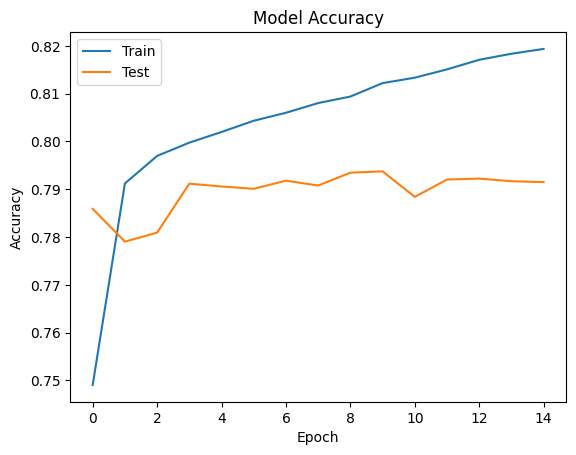

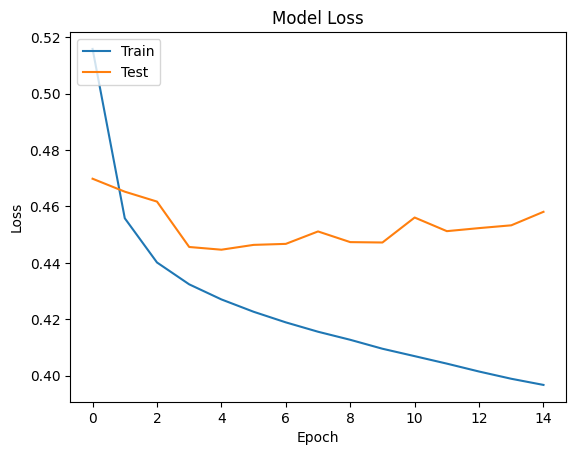

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


37500/37500 [==============================] - 69s 2ms/step


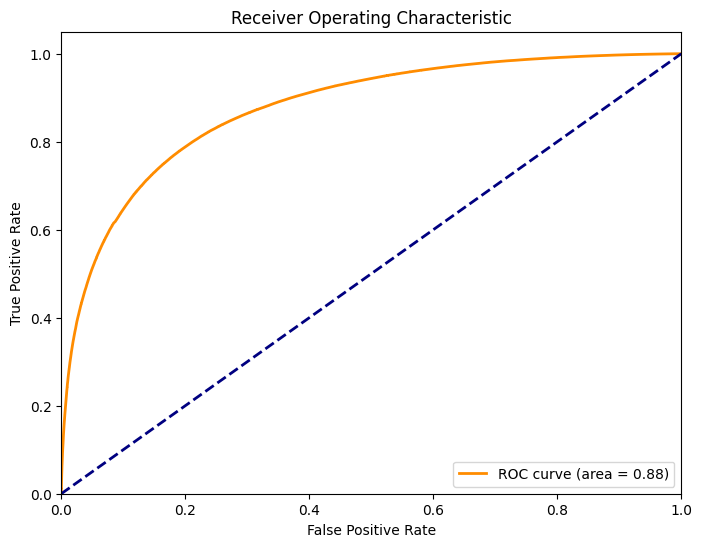

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred_probs = model.predict(X_test).flatten()

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


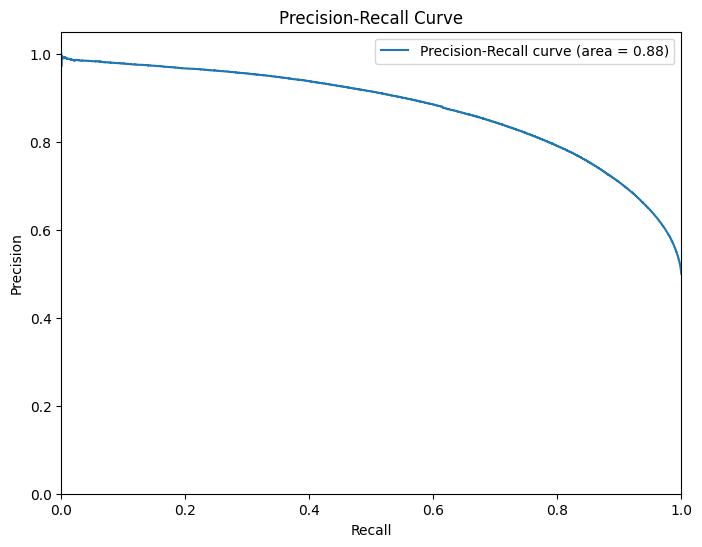

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Calculate average precision
average_precision = average_precision_score(y_test, y_pred_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


#**User_inputs**

In [25]:
# Initialize a list to store user inputs
user_inputs = []

from ipywidgets import widgets, Button, Text
from IPython.display import display, clear_output

# Load the trained model
model = tf.keras.models.load_model("sentiment_analysis_model.h5")

# List to store user inputs
user_inputs = []



In [26]:
def preprocess_for_prediction(text):
    # Cleaning the text
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)  # Remove URLs and mentions
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)         # Keep only letters
    text = re.sub(r'\s+', ' ', text).strip()         # Remove extra spaces

    # Tokenizing and padding
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=200, padding='post', truncating='post')
    return padded_sequence



In [27]:
# UI function for sentiment prediction
def ui_predict_sentiment(button):
    clear_output()
    new_tweet = text_input.value
    user_inputs.append(new_tweet)  # Log the user input
    processed_tweet = preprocess_for_prediction(new_tweet)
    prediction = model.predict(processed_tweet)
    sentiment = "Positive" if prediction[0][0] > 0.5 else "Negative"
    print(f"The sentiment of the tweet is: {sentiment}")
    print("Recent tweets analyzed:")
    for tweet in user_inputs[-5:]:  # Display the last 5 inputs
        print(tweet)

# Create text input widget
text_input = Text(description="Tweet: ")

# Create button and bind the prediction function
predict_button = Button(description="Predict Sentiment")
predict_button.on_click(ui_predict_sentiment)

# Display UI components
display(text_input, predict_button)


1/1 [==============================] - 0s 63ms/step
The sentiment of the tweet is: Negative
Recent tweets analyzed:
The more I use @salesforce the more I dislike it. It's slow and full of bugs. There are elements of the UI that look like they haven't been updated since 2006. Current frustration: app exchange pages won't stop refreshing every 10 second
